**M5:** Image classification from M3

In [137]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data
import torchvision.transforms as transforms
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torch.optim import lr_scheduler

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
%%capture
!unzip /content/drive/My\ Drive/Colab\ Notebooks/MCV/M3/MIT_split.zip -d /content/

In [0]:
# Example NN (working, acc=0.6)
import torch.nn as nn
import torch.nn.functional as F

class ExampleNN(nn.Module):
    def __init__(self):
        super(ExampleNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [0]:
# First approach:
import torch.nn.functional as F

# Create our custom class for the NN
class ClassificationNN(nn.Module):
  def __init__(self, input_size, num_classes):
    super(ClassificationNN, self).__init__()
    self.input_size = input_size
    self.num_classes = num_classes
    self.relu = nn.ReLU()
    self.softmax = nn.Softmax(dim=1)
    self.conv1 = nn.Conv2d(3, 64, 3)
    self.bn64 = nn.BatchNorm2d(64)
    self.bn32 = nn.BatchNorm2d(32)
    self.bn = nn.BatchNorm2d(16)
    self.conv2 = nn.Conv2d(64, 32, 1)
    self.conv3 = nn.Conv2d(32, 32, 3)
    self.conv4 = nn.Conv2d(32, 16, 1)
    self.conv5 = nn.Conv2d(16, 32, 3)
    self.conv6 = nn.Conv2d(32, 16, 3)
    self.pool = nn.MaxPool2d(2, 2)
    self.fc = nn.Linear(16,8)
    self.avgpool = nn.AvgPool2d(24)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = self.bn64(x)
    x = F.relu(self.conv2(x))
    x = F.relu(self.conv3(x))
    x = self.pool(x)
    x = self.bn32(x)
    x = F.relu(self.conv4(x))
    x = F.relu(self.conv5(x))
    x = self.pool(x)
    x = self.bn32(x)
    x = F.relu(self.conv6(x))
    x = self.avgpool(x)
    x = self.bn(x)
    x = x.view(-1,16)
    x = self.fc(x)
    output = self.softmax(x)
    return(x)

In [0]:
class CustomResidualNetwork(nn.Module):
  def __init__(self, input_size, num_classes):
      super(CustomResidualNetwork, self).__init__()
      self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=2, bias=False)
      self.bn1 = nn.BatchNorm2d(32)
      self.conv2 = nn.Conv2d(32, 32, kernel_size=1, stride=1, padding=0, bias=False)
      self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=2, bias=False)
      self.fc = nn.Linear(32,num_classes)
      self.globalAveragePool = nn.AvgPool2d(int(input_size/4))

  def forward(self, x):
      # First block
      out = F.relu(self.bn1(self.conv1(x)))
      out = out + self.bn1(self.conv2(out))
      out = F.relu(out)

      # Second block
      out = self.bn1(self.conv3(out))
      out = F.relu(out)

      # Final layers
      out = self.globalAveragePool(out)
      out = out.view(out.size(0), -1)
      out = self.fc(out)
      return out

In [0]:
# Some constants
INPUT_SIZE = 64
BATCH_SIZE = 32
NUM_CLASSES = 8

# Define the NN
net = CustomResidualNetwork(INPUT_SIZE, NUM_CLASSES)
net.cuda()

# Create the dataloaders
transform = {
        'train': transforms.Compose(
            [transforms.Resize([INPUT_SIZE, INPUT_SIZE]),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])]),
        'test': transforms.Compose(
            [transforms.Resize([INPUT_SIZE, INPUT_SIZE]),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])])
        }

trainData = torchvision.datasets.ImageFolder(root = 'train', transform=transform['train'])
testData = torchvision.datasets.ImageFolder(root = 'test', transform=transform['test'])

data_loader_train = torch.utils.data.DataLoader(trainData, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
data_loader_test = torch.utils.data.DataLoader(testData, batch_size=BATCH_SIZE)

In [0]:
# Create the optimizer
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

In [149]:
# Check the tensor size
for i, data in enumerate(data_loader_train, 0):
    # get the inputs
    inputs, labels = data
    print(np.shape(inputs))
    break

torch.Size([32, 3, 64, 64])


[1,    10] Train loss: 1.955
[1,    10] Train acc: 0.281
[1,    20] Train loss: 1.787
[1,    20] Train acc: 0.316
[1,    30] Train loss: 1.743
[1,    30] Train acc: 0.334
[1,    40] Train loss: 1.645
[1,    40] Train acc: 0.391
[1,    50] Train loss: 1.499
[1,    50] Train acc: 0.491
Epoch train accuracy  0.37823275862068967
Epoch val accuracy  0.19454770755885997
[2,    10] Train loss: 1.889
[2,    10] Train acc: 0.237
[2,    20] Train loss: 1.765
[2,    20] Train acc: 0.347
[2,    30] Train loss: 1.721
[2,    30] Train acc: 0.353
[2,    40] Train loss: 1.554
[2,    40] Train acc: 0.447
[2,    50] Train loss: 1.598
[2,    50] Train acc: 0.416
Epoch train accuracy  0.3739224137931034
Epoch val accuracy  0.45229244114002476
[3,    10] Train loss: 1.529
[3,    10] Train acc: 0.431
[3,    20] Train loss: 1.516
[3,    20] Train acc: 0.422
[3,    30] Train loss: 1.606
[3,    30] Train acc: 0.403
[3,    40] Train loss: 1.476
[3,    40] Train acc: 0.494
[3,    50] Train loss: 1.440
[3,    50]

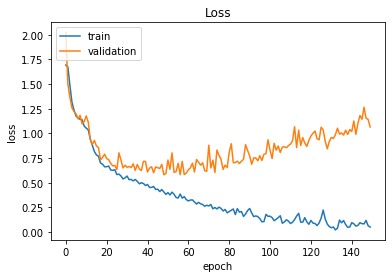

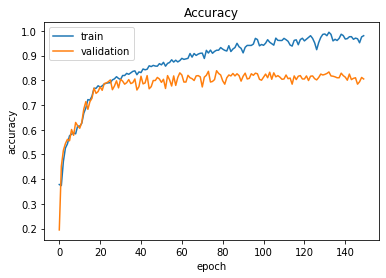

In [150]:
# TRAINING #
NUM_EPOCHS = 150

hist_train_loss = []
hist_train_acc = []
hist_val_loss = []
hist_val_acc = []

for epoch in range(NUM_EPOCHS):  # loop over the dataset multiple times
    epoch_train_loss = 0.0
    epoch_train_acc = 0.0
    train_loss = 0.0
    valid_loss = 0.0
    train_acc = 0.0
    val_acc = 0.0
    for i, data in enumerate(data_loader_train, 0):
        #net.train()
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Compute statistics
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        batch_acc = (predicted == labels).sum().item()/BATCH_SIZE
        train_acc += batch_acc
        epoch_train_loss += loss.item()
        epoch_train_acc += batch_acc
        if i % 10 == 9:    # log every 10 mini-batches
            print('[%d, %5d] Train loss: %.3f' %
                  (epoch + 1, i + 1, train_loss / 10))
            print('[%d, %5d] Train acc: %.3f' %
                  (epoch + 1, i + 1, train_acc / 10))
            train_loss = 0.0
            train_acc = 0.0
        exp_lr_scheduler.step()
    
    # Pass through the validation data and log the results
    correct = 0
    total = 0
    val_loss = 0
    net.eval()
    for data in data_loader_test:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        outputs = net(images)
        vloss = criterion(outputs, labels)
        val_loss += vloss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    hist_val_acc.append(correct/total)
    hist_val_loss.append(val_loss/len(data_loader_test))
    hist_train_acc.append(epoch_train_acc/len(data_loader_train))
    hist_train_loss.append(epoch_train_loss/len(data_loader_train))
    print("Epoch train accuracy ", epoch_train_acc/len(data_loader_train))
    print("Epoch val accuracy ", correct/total)


print('Finished Training, plotting history...')

plt.title('Loss')
plt.plot(hist_train_loss)
plt.plot(hist_val_loss)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.title('Accuracy')
plt.plot(hist_train_acc)
plt.plot(hist_val_acc)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [0]:
classes = ('Opencountry', 'coast', 'forest', 'highway',
           'inside_city', 'mountain', 'street', 'tallbuilding')
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [151]:
correct = 0
total = 0
with torch.no_grad():
    for data in data_loader_test:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 80 %


In [152]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in data_loader_test:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(NUM_CLASSES):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of Opencountry : 81 %
Accuracy of coast : 81 %
Accuracy of forest : 91 %
Accuracy of highway : 87 %
Accuracy of inside_city : 100 %
Accuracy of mountain : 81 %
Accuracy of street : 75 %
Accuracy of tallbuilding : 87 %
